## Neural Network Approach for Seasonal Items Forecasting of a Retail Store
## All models in one notebook + Results and Comparison

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import seaborn as sns
from statsmodels.graphics import tsaplots
import statsmodels.api as sm
from pylab import rcParams
import itertools
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import sys

from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import Bidirectional
from keras.layers import LSTM
import warnings

from keras.layers import RepeatVector
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from sklearn.metrics import mean_squared_error

import os

from pandas import datetime
from pandas import DataFrame
from pandas import concat
from pandas import Series

<ipython-input-1-0dcdfe87a40f>:35: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import sys
sys.path.append('/content/drive/MyDrive')

In [4]:
sys.path

['/content',
 '/env/python',
 '/usr/lib/python310.zip',
 '/usr/lib/python3.10',
 '/usr/lib/python3.10/lib-dynload',
 '',
 '/usr/local/lib/python3.10/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.10/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/drive/MyDrive']

In [5]:
import os
print(os.getcwd())

/content


In [6]:
import os
import pandas as pd

# Define the full path to the Excel file in Google Drive
excel_path = './drive/MyDrive/data/MRP_data.xls'

# Check if the file exists
if os.path.exists(excel_path):
    data = pd.read_excel(excel_path)
    print(data.head())
else:
    print(f"Error: The file '{excel_path}' does not exist.")

   Row ID        Order ID Order Date  Ship Date       Ship Mode Customer ID  \
0       1  CA-2016-152156 2016-11-08 2016-11-11    Second Class    CG-12520   
1       2  CA-2016-152156 2016-11-08 2016-11-11    Second Class    CG-12520   
2       3  CA-2016-138688 2016-06-12 2016-06-16    Second Class    DV-13045   
3       4  US-2015-108966 2015-10-11 2015-10-18  Standard Class    SO-20335   
4       5  US-2015-108966 2015-10-11 2015-10-18  Standard Class    SO-20335   

     Customer Name    Segment        Country             City  ...  \
0      Claire Gute   Consumer  United States        Henderson  ...   
1      Claire Gute   Consumer  United States        Henderson  ...   
2  Darrin Van Huff  Corporate  United States      Los Angeles  ...   
3   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   
4   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   

  Postal Code  Region       Product ID         Category Sub-Category  \
0       42420   South  FUR-BO-10

## Edit columns names

In [7]:
# Lower case column names
data.columns = map(str.lower, data.columns)

#Replace spaces with '_'
data.columns = data.columns.str.replace(" ", "_")
data.columns = data.columns.str.replace("-", "_")
data.columns

Index(['row_id', 'order_id', 'order_date', 'ship_date', 'ship_mode',
       'customer_id', 'customer_name', 'segment', 'country', 'city', 'state',
       'postal_code', 'region', 'product_id', 'category', 'sub_category',
       'product_name', 'sales', 'quantity', 'discount', 'profit'],
      dtype='object')

## Separate dataframe of each category

In [8]:
furniture=data.loc[data['category'] == 'Furniture']

technology=data.loc[data['category'] == 'Technology']
office=data.loc[data['category'] == 'Office Supplies']

## Aggregating sales data by date

In [9]:
furniture= furniture.groupby('order_date')['sales'].sum().reset_index()

technology= technology.groupby('order_date')['sales'].sum().reset_index()
office= office.groupby('order_date')['sales'].sum().reset_index()

In [10]:
#Set index
furniture = furniture.set_index('order_date')

technology = technology.set_index('order_date')
office = office.set_index('order_date')

In [ ]:
#furniture['sales']

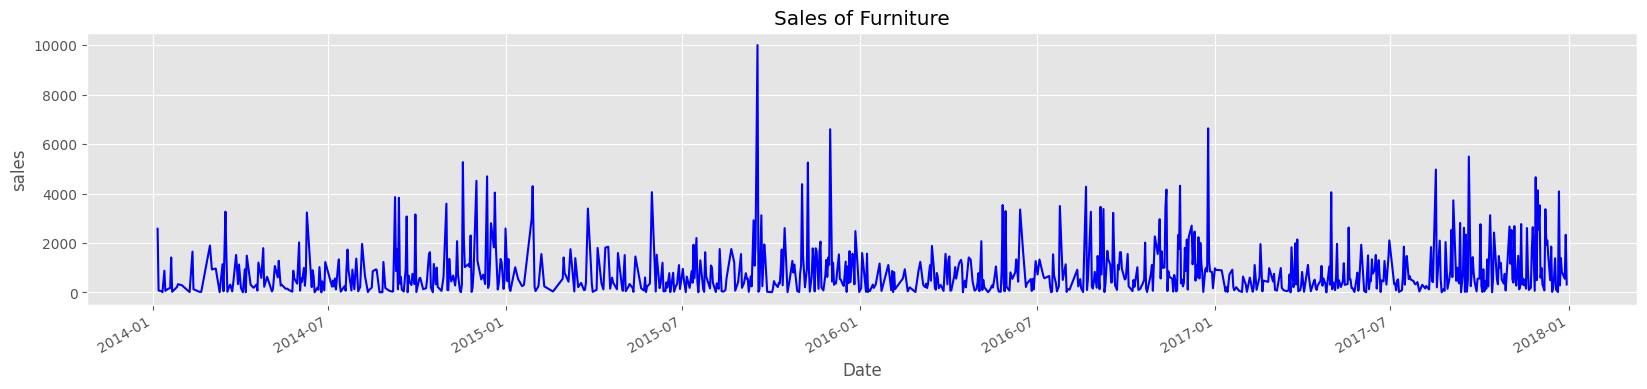

In [11]:
ax= furniture['sales'].plot(color='blue',figsize=(20,4))
ax.set_xlabel("Date")
ax.set_ylabel('sales')
ax.set_title("Sales of Furniture")
plt.show()

In [12]:
def performance(y_true, y_pred):
    mse = ((y_pred - y_true) ** 2).mean()
    mape= np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    performance_data= {'MSE':round(mse, 2),
                      'RMSE':round(np.sqrt(mse), 2),
                       'MAPE':round(mape, 2)
                      }
    return performance_data

def performance2(y_true, y_pred):
    #y_true, y_pred = np.array(y_true), np.array(y_pred)
    mse = ((y_pred - y_true) ** 2).mean()
    mape= np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return( print(' The MSE of forecasts is {}'.format(round(mse, 2))+
                  '\n The RMSE of forecasts is {}'.format(round(np.sqrt(mse), 2))+
                  '\n The MAPE of forecasts is {}'.format(round(mape, 2))))

In [15]:
df = furniture['sales'].resample('MS').mean()

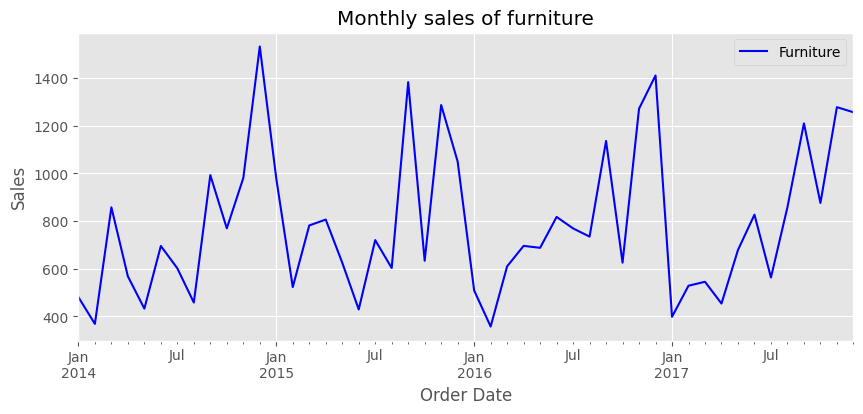

In [16]:
df.plot(figsize=(10, 4),color='blue',label = 'Furniture')
plt.xlabel("Order Date")
plt.ylabel('Sales')
plt.title("Monthly sales of furniture")
plt.legend()
plt.show()

## Seasonal decomposition:

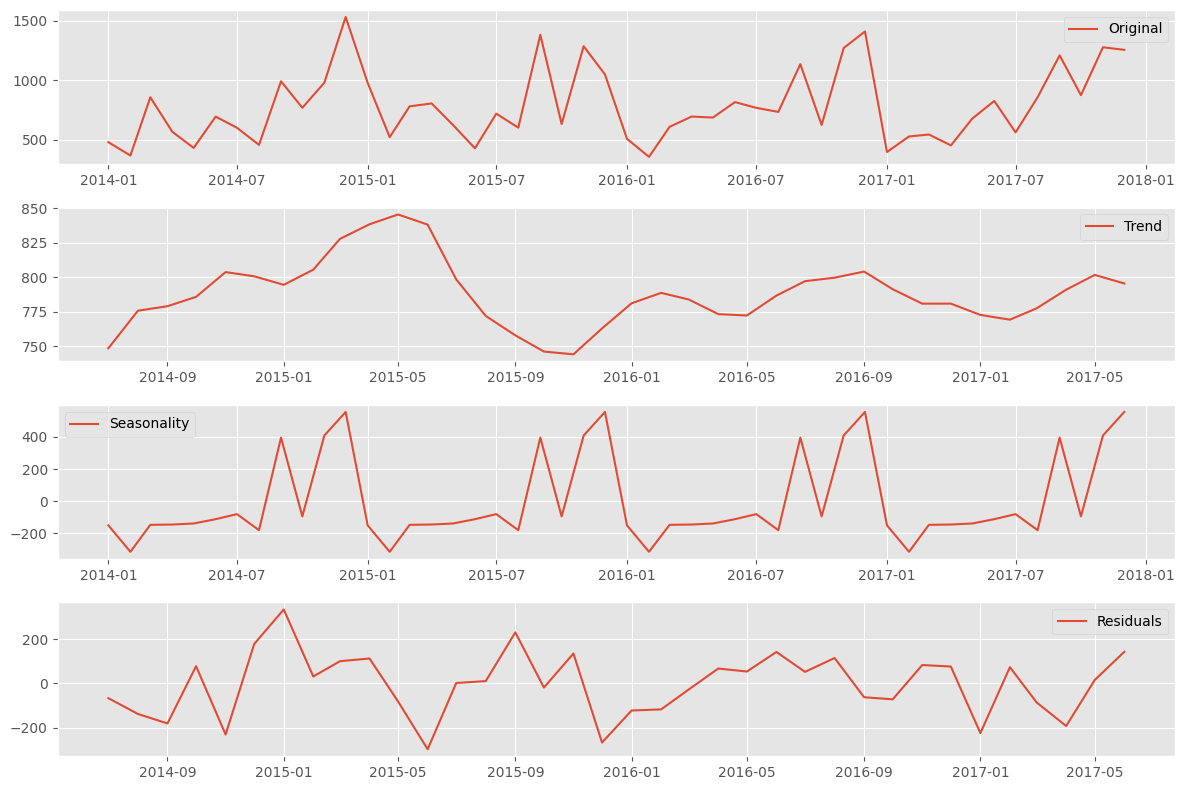

In [17]:
#Furniture time-series decomposition
decomposition = seasonal_decompose(df,period=12)
rcParams['figure.figsize'] = 12, 8

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(df, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [18]:
def test_stationarity(timeseries):
    rcParams['figure.figsize'] = 10, 6
    rolmean = timeseries.rolling(12).mean() #allows you to calculate moving avg
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    print('p-value=', dftest[1])

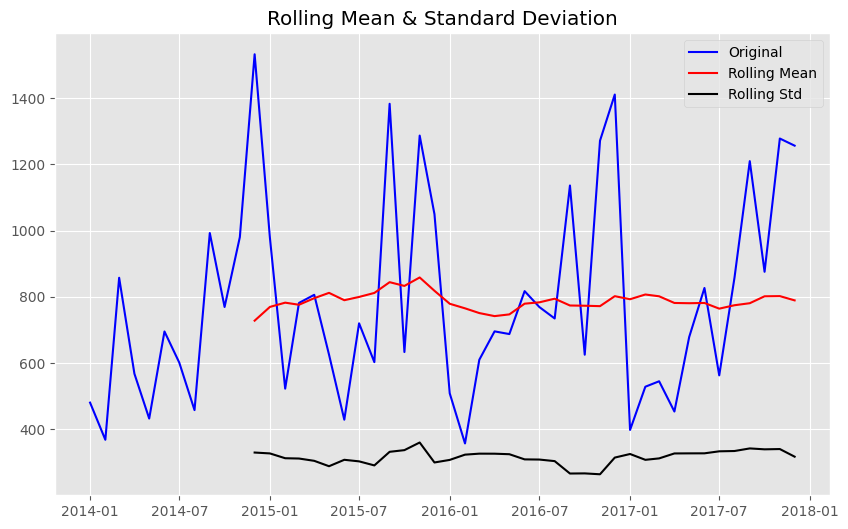

Results of Dickey-Fuller Test:
p-value= 9.1687566556655e-06


In [19]:
#check to see if the time-series is stationary or non-stationary
test_stationarity(df)
#p-value= 9.168756655665942e-06

### Train and test split

In [20]:
X = df
train_size = int(len(X) * 0.75)
trainset, testset= X[0:train_size], X[train_size:]

In [21]:
trainset

order_date
2014-01-01     480.194231
2014-02-01     367.931600
2014-03-01     857.291529
2014-04-01     567.488357
2014-05-01     432.049188
2014-06-01     695.059242
2014-07-01     601.169500
2014-08-01     457.521656
2014-09-01     992.353367
2014-10-01     769.015437
2014-11-01     980.221486
2014-12-01    1532.298325
2015-01-01     978.328467
2015-02-01     522.395667
2015-03-01     781.236437
2015-04-01     805.822962
2015-05-01     624.996700
2015-06-01     428.565500
2015-07-01     719.706316
2015-08-01     602.412012
2015-09-01    1382.790684
2015-10-01     632.980184
2015-11-01    1286.701354
2015-12-01    1049.355418
2016-01-01     508.182867
2016-02-01     356.868273
2016-03-01     609.575810
2016-04-01     695.373158
2016-05-01     687.265227
2016-06-01     816.910750
2016-07-01     768.736412
2016-08-01     734.307782
2016-09-01    1135.953371
2016-10-01     624.872474
2016-11-01    1271.345152
2016-12-01    1410.719808
Freq: MS, Name: sales, dtype: float64

In [22]:
testset

order_date
2017-01-01     397.602133
2017-02-01     528.179800
2017-03-01     544.672240
2017-04-01     453.297905
2017-05-01     678.302328
2017-06-01     826.460291
2017-07-01     562.524857
2017-08-01     857.881889
2017-09-01    1209.508583
2017-10-01     875.362728
2017-11-01    1277.817759
2017-12-01    1256.298672
Freq: MS, Name: sales, dtype: float64

In [23]:
train, test = np.array(df[:-12]), np.array(df[-12:])
print(train)
print(test)
train= train.reshape(-1,1)
test= test.reshape(-1,1)

[ 480.19423077  367.9316      857.29152941  567.48835714  432.0491875
  695.05924211  601.1695      457.52165625  992.35336667  769.0154375
  980.22148636 1532.298325    978.32846667  522.39566667  781.2364375
  805.82296154  624.9967      428.5655      719.70631579  602.4120125
 1382.79068421  632.98018421 1286.70135417 1049.35541818  508.18286667
  356.86827273  609.57580952  695.37315789  687.26522727  816.91075
  768.73641176  734.30778235 1135.95337083  624.87247368 1271.345152
 1410.71980769]
[ 397.60213333  528.1798      544.67224     453.297905    678.302328
  826.4602913   562.52485714  857.88188889 1209.50858333  875.362728
 1277.81775862 1256.298672  ]


In [24]:
train

array([[ 480.19423077],
       [ 367.9316    ],
       [ 857.29152941],
       [ 567.48835714],
       [ 432.0491875 ],
       [ 695.05924211],
       [ 601.1695    ],
       [ 457.52165625],
       [ 992.35336667],
       [ 769.0154375 ],
       [ 980.22148636],
       [1532.298325  ],
       [ 978.32846667],
       [ 522.39566667],
       [ 781.2364375 ],
       [ 805.82296154],
       [ 624.9967    ],
       [ 428.5655    ],
       [ 719.70631579],
       [ 602.4120125 ],
       [1382.79068421],
       [ 632.98018421],
       [1286.70135417],
       [1049.35541818],
       [ 508.18286667],
       [ 356.86827273],
       [ 609.57580952],
       [ 695.37315789],
       [ 687.26522727],
       [ 816.91075   ],
       [ 768.73641176],
       [ 734.30778235],
       [1135.95337083],
       [ 624.87247368],
       [1271.345152  ],
       [1410.71980769]])

### Measure of prediction accuracy

In [25]:
def performance(y_true, y_pred):
    mse = ((y_pred - y_true) ** 2).mean()
    mape= np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    performance_data= {'MSE':round(mse, 2),
                      'RMSE':round(np.sqrt(mse), 2),
                       'MAPE':round(mape, 2)
                      }
    return performance_data

def performance2(y_true, y_pred):
    #y_true, y_pred = np.array(y_true), np.array(y_pred)
    mse = ((y_pred - y_true) ** 2).mean()
    mape= np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return( print(' The MSE of forecasts is {}'.format(round(mse, 2))+
                  '\n The RMSE of forecasts is {}'.format(round(np.sqrt(mse), 2))+
                  '\n The MAPE of forecasts is {}'.format(round(mape, 2))))

In [28]:
!pip install statsmodels

## ARIMA model

### Grid Search

In [34]:
import warnings
from pandas import Series
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# evaluate an ARIMA model
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.75)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

# evaluate the combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [38]:
# evaluate parameters
p_values = [0, 1, 2, 4,6]
d_values = range(0, 2)
q_values = range(0, 2)
warnings.filterwarnings("ignore")
evaluate_models(df.values, p_values, d_values, q_values)

Best ARIMANone MSE=inf


In [39]:
from statsmodels.tsa.arima.model import ARIMA
model_arima = ARIMA(trainset, order = (6,0,0))
model_arima_fit = model_arima.fit()
arima_predict = model_arima_fit.predict(start=pd.to_datetime('2017-01-01'), end=pd.to_datetime('2017-12-01')
                                           ,dynamic=False)

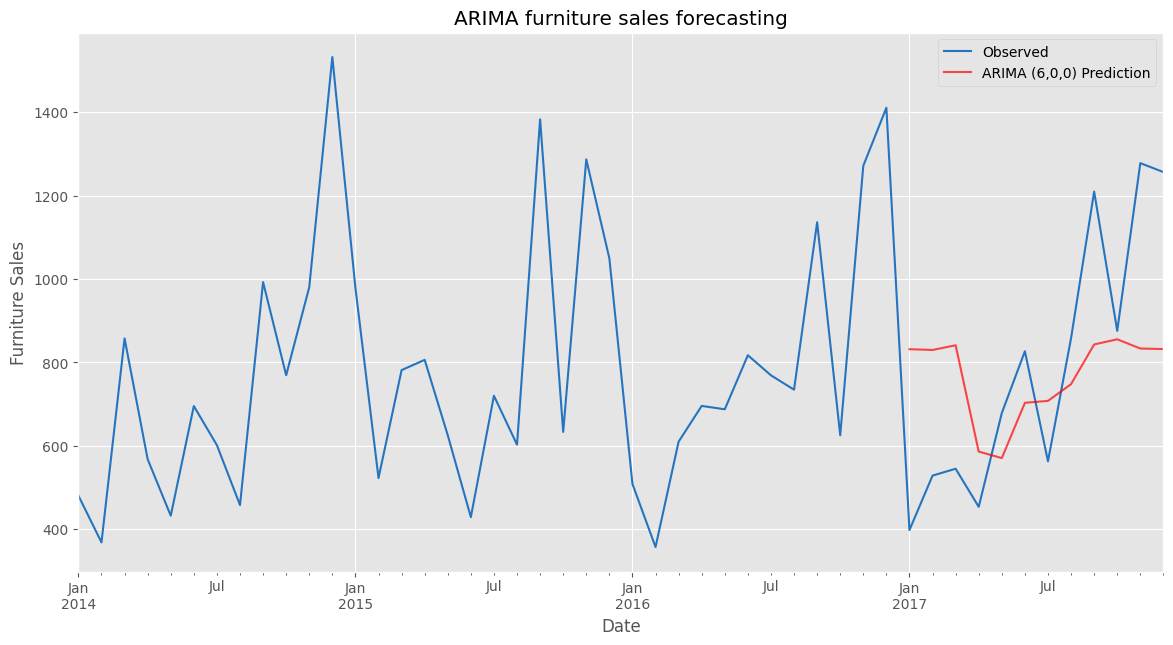

In [40]:
# One step ahead forecast
#observed plot
ax = df.plot(label='Observed',color='#2574BF')
#predicted plot
rcParams['figure.figsize'] = 14, 7
arima_predict.plot(ax=ax, label='ARIMA (6,0,0) Prediction', alpha= 0.7, color='red')
plt.title('ARIMA furniture sales forecasting')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend()
plt.show()

In [41]:
arima_results= performance(df[-12:],arima_predict)
arima_results

{'MSE': 79779.2, 'RMSE': 282.45, 'MAPE': 35.04}

## ACF plot

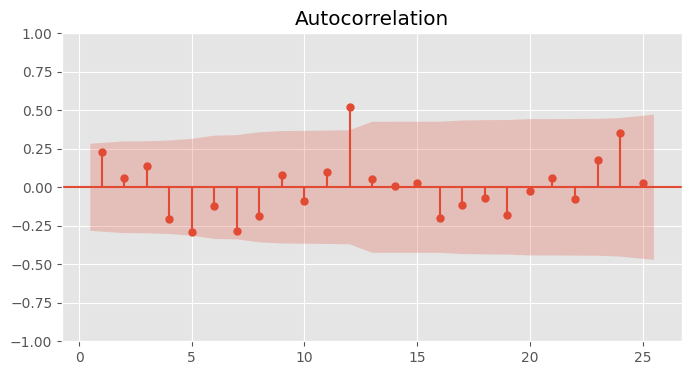

In [43]:
from statsmodels.graphics.tsaplots import plot_acf
fig,ax = plt.subplots(1,1,figsize=(8,4))
plot_acf(df,ax=ax,zero=False,lags=25)
plt.show()

#From the peaks we can see that the frequency is 12

## Seasonal ARIMA model

### Grid search method 1 - using auto-ARIMA that reported back the best AIC value.

In [45]:
## Find optimal order
!pip install pmdarima
import pmdarima as pm
model_1 = pm.auto_arima(trainset,seasonal=True, m=12,d=0, D=1, max_p=2, max_q=2,
                       trace=True,error_action='ignore',suppress_warnings=True)

# Print model summary
print(model_1.summary())

#best model is Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 1, 0, 12); AIC=329.940,

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 8.3 MB/s eta 0:00:00
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=1.34 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=338.682, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=330.948, Time=0.33 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=337.169, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=340.006, Time=0.10 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=inf, Time=1.21 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=333.147, Time=0.58 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.10 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=329.174, Time=0.47 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=inf, Time=2.00 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=331.153, Time=1.51 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=in

### Fitting the model

In [46]:
#fitting model
sarima_model_1 = sm.tsa.statespace.SARIMAX(trainset,
                                order=(0, 0, 0),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
sarima_fit_1 = sarima_model_1.fit()
print(sarima_fit_1.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.6292      0.176     -3.570      0.000      -0.975      -0.284
sigma2       2.25e+04   1.57e+04      1.429      0.153   -8356.220    5.34e+04


### Validating forecasts

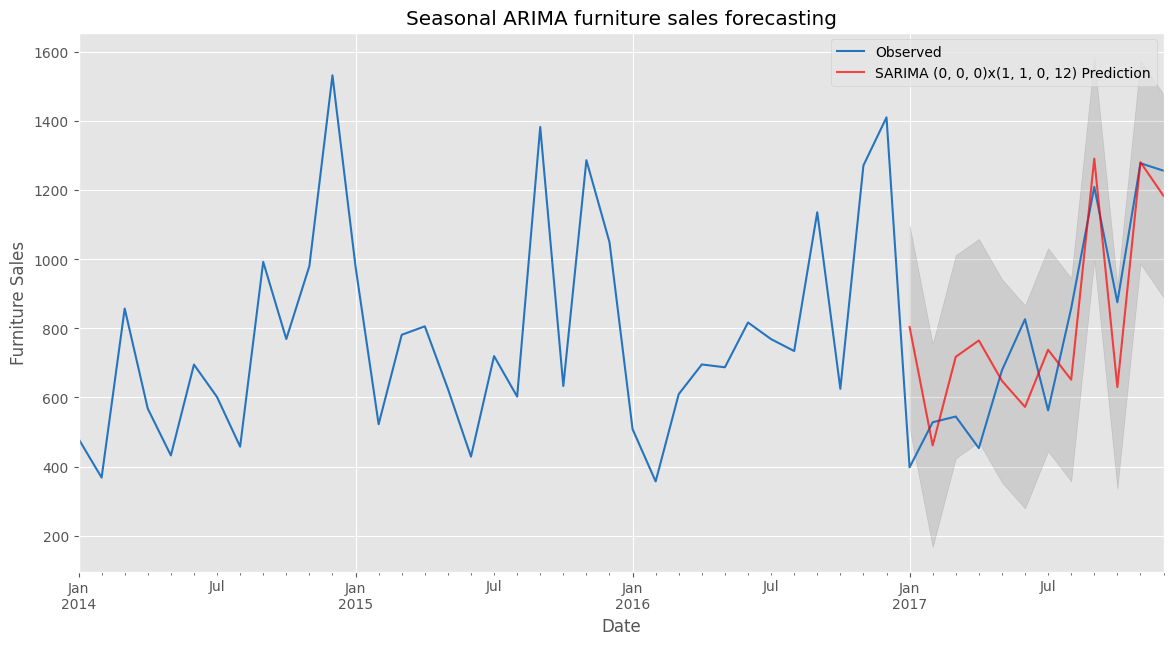

In [48]:
# One step ahead forecast
sarima_predict_1 = sarima_fit_1.get_prediction(start=pd.to_datetime('2017-01-01'), end=pd.to_datetime('2017-12-01')
                                           ,dynamic=False)
sarima_predict_conf_1 = sarima_predict_1.conf_int()
#observed plot
ax = df.plot(label='Observed',color='#2574BF')
#predicted plot
rcParams['figure.figsize'] = 14, 7
sarima_predict_1.predicted_mean.plot(ax=ax, label='SARIMA (0, 0, 0)x(1, 1, 0, 12) Prediction', alpha= 0.7, color='red')
ax.fill_between(sarima_predict_conf_1.index,
                #lower sales
                sarima_predict_conf_1.iloc[:, 0],
                #upper sales
                sarima_predict_conf_1.iloc[:, 1], color='k', alpha=0.1)
plt.title('Seasonal ARIMA furniture sales forecasting')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend()
plt.show()


In [49]:
sarima_results=performance(df[-12:],sarima_predict_1.predicted_mean)
sarima_results

{'MSE': 42305.37, 'RMSE': 205.68, 'MAPE': 28.89}

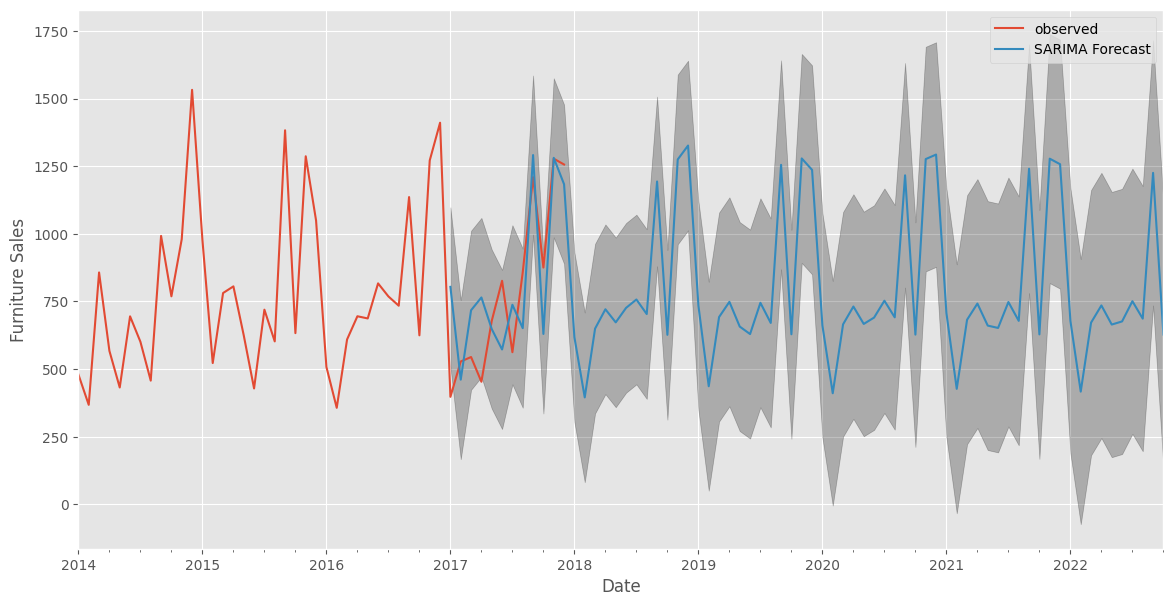

In [50]:
furthur_predict_1 = sarima_fit_1.get_forecast(steps=70)
furthur_conf_1 = furthur_predict_1.conf_int()
ax = df.plot(label='observed', figsize=(14, 7))
furthur_predict_1.predicted_mean.plot(ax=ax, label='SARIMA Forecast')
ax.fill_between(furthur_conf_1.index,
                furthur_conf_1.iloc[:, 0],
                furthur_conf_1.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

### Grid Search meethod 2 - Develop a Grid Search Framework

In [51]:
# Define the p, d and q parameters to take a value between 0 and 2
p = d = q = range(0, 2)

# Generate different combinations of p, d and q
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [52]:
#method 2
warnings.filterwarnings("ignore")
lowest_aic = sys.maxsize
lowest = ''

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(trainset,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()

            print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))

            if lowest_aic >  results.aic:
                lowest = 'SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic)
                lowest_aic = results.aic
        except:
            continue

print ("The lowes AIC belongs to "+lowest)

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:573.2736548047211
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:363.64804539895664
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:320.39031701091477
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:145.13133504245582
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:339.13659906594717
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:319.05810973857683
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:158.31115188193314
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:146.42796771587655
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:535.9560974912333
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:338.86219019743174
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:308.9827688113516
SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:130.25791565352958
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:340.55729582952995
SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:307.94590618893284
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:158.06483656134904
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:134.4343024789221
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:501.6523533373235
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AI

### Fitting the model

In [53]:
#fitting model
sarima_model_2 = sm.tsa.statespace.SARIMAX(trainset,
                                order=(1, 1, 0),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
sarima_fit_2 = sarima_model_2.fit()
print(sarima_fit_2.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1918      0.371     -0.517      0.606      -0.920       0.536
ar.S.L12      -0.4818      0.165     -2.922      0.003      -0.805      -0.159
sigma2      2.266e+04    1.8e+04      1.259      0.208   -1.26e+04    5.79e+04


### Validating forecasts

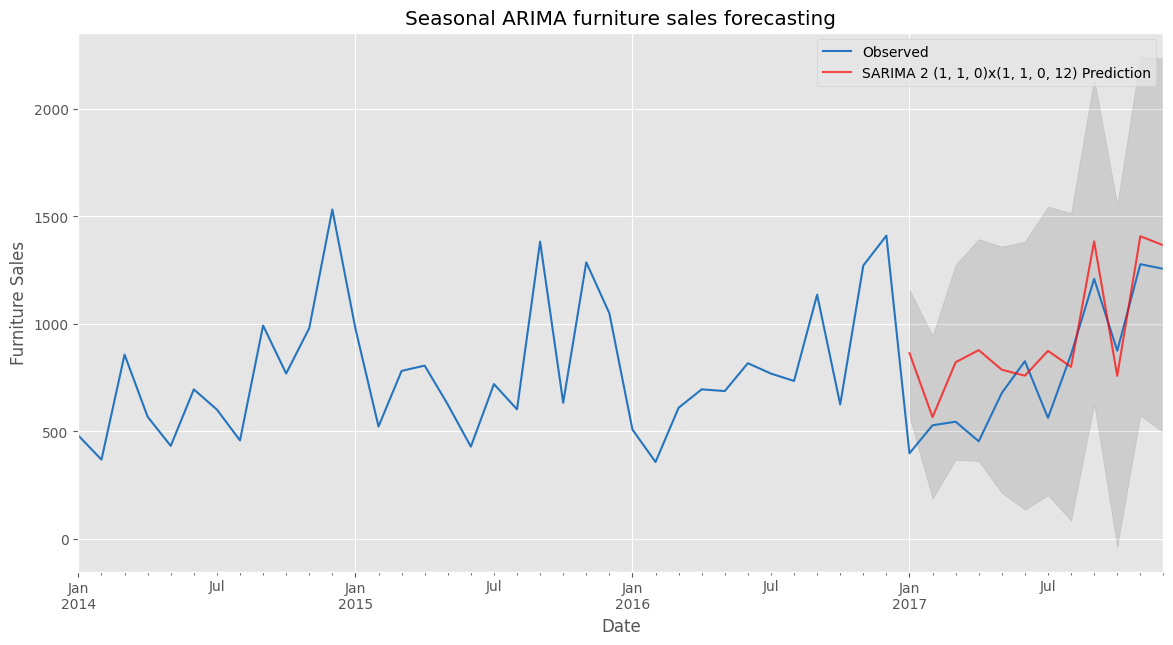

In [54]:
# One step ahead forecast
sarima_predict_2 = sarima_fit_2.get_prediction(start=pd.to_datetime('2017-01-01'), end=pd.to_datetime('2017-12-01')
                                           ,dynamic=False)
sarima_predict_conf_2 = sarima_predict_2.conf_int()
#observed plot
ax = df.plot(label='Observed',color='#2574BF')
#predicted plot
rcParams['figure.figsize'] = 14, 7
sarima_predict_2.predicted_mean.plot(ax=ax, label='SARIMA 2 (1, 1, 0)x(1, 1, 0, 12) Prediction', alpha= 0.7, color='red')
ax.fill_between(sarima_predict_conf_2.index,
                #lower sales
                sarima_predict_conf_2.iloc[:, 0],
                #upper sales
                sarima_predict_conf_2.iloc[:, 1], color='k', alpha=0.1)
plt.title('Seasonal ARIMA furniture sales forecasting')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend()
plt.show()


In [55]:
sarima_results2=performance(df[-12:],sarima_predict_2.predicted_mean)
sarima_results2

{'MSE': 55497.86, 'RMSE': 235.58, 'MAPE': 33.5}

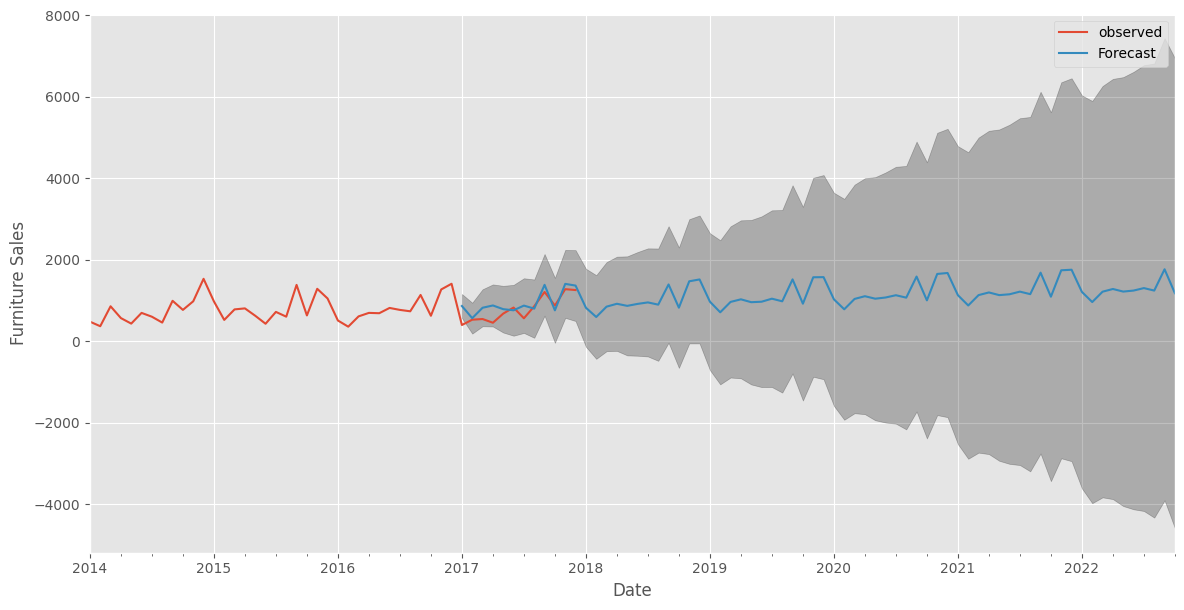

In [56]:
furthur_predict_2 = sarima_fit_2.get_forecast(steps=70)
furthur_conf_2 = furthur_predict_2.conf_int()
ax = df.plot(label='observed', figsize=(14, 7))
furthur_predict_2.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(furthur_conf_2.index,
                furthur_conf_2.iloc[:, 0],
                furthur_conf_2.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

## Double exponential smoothing

In [57]:
warnings.filterwarnings("ignore")
from statsmodels.tsa.holtwinters import ExponentialSmoothing

DES = ExponentialSmoothing(trainset, trend = 'add')
DES_fit = DES.fit(smoothing_level=0.5)
DES_predict = DES_fit.predict(start=pd.to_datetime('2017-01-01'), end=pd.to_datetime('2017-12-01'))

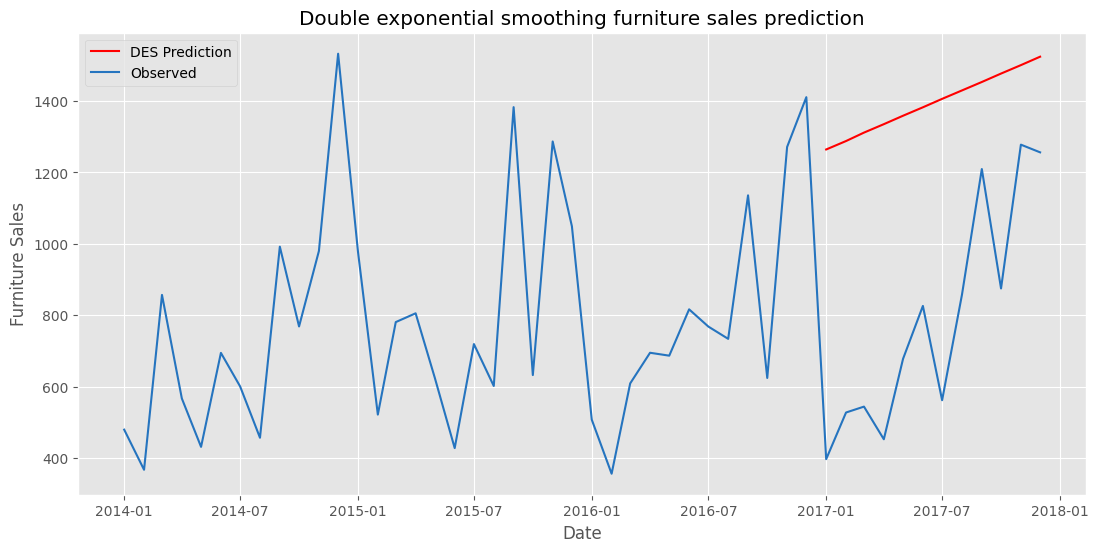

In [58]:
from pylab import rcParams
rcParams['figure.figsize'] = 13, 6
yhat_DES = DES_predict.values.tolist()
y = df.values.tolist()
plt.plot(DES_predict.index, yhat_DES, color='r',label='DES Prediction')
plt.plot(df.index, y, color='#2574BF',label='Observed')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend()
plt.title('Double exponential smoothing furniture sales prediction')
plt.show()

In [59]:
DES_results=performance(df[-12:], yhat_DES)
DES_results

{'MSE': 420545.71, 'RMSE': 648.49, 'MAPE': 100.74}

### Triple exponential smoothing

In [60]:
#Prediction with exponential smoothing + seasonality
from statsmodels.tsa.holtwinters import ExponentialSmoothing
TES = ExponentialSmoothing(trainset, trend = 'add', seasonal = 'add', seasonal_periods = 12)
TES_fit = TES.fit(smoothing_level=0.5)
TES_predict = TES_fit.predict(start=pd.to_datetime('2017-01-01'), end=pd.to_datetime('2017-12-01'))

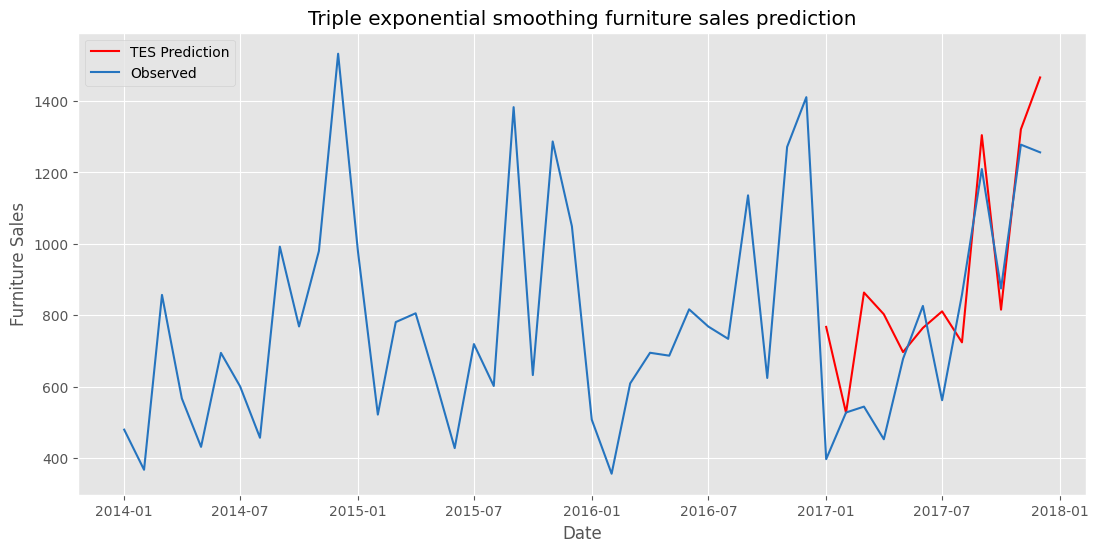

In [61]:
from pylab import rcParams
rcParams['figure.figsize'] = 13, 6
yhat_TES = TES_predict.values.tolist()
y = df.values.tolist()
plt.plot(TES_predict.index, yhat_TES, color='r',label='TES Prediction')
plt.plot(df.index, y, color='#2574BF',label='Observed')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend()
plt.title('Triple exponential smoothing furniture sales prediction')
plt.show()

In [62]:
TES_results= performance(df[-12:], yhat_TES)
TES_results

{'MSE': 41955.36, 'RMSE': 204.83, 'MAPE': 27.81}

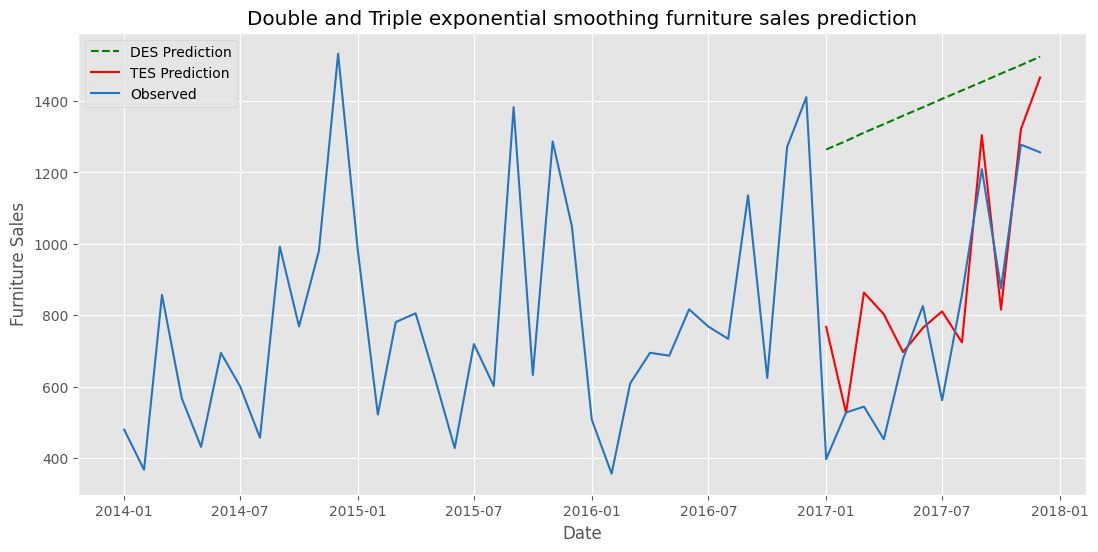

In [63]:
from pylab import rcParams
rcParams['figure.figsize'] = 13, 6
plt.plot(DES_predict.index, yhat_DES, color='g',linestyle= "--",label='DES Prediction')
plt.plot(TES_predict.index, yhat_TES, color='r',label='TES Prediction')
plt.plot(df.index, y, color='#2574BF',label='Observed')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend()
plt.title('Double and Triple exponential smoothing furniture sales prediction')
plt.show()

## Prophet Method

### Prophet First model

In [64]:
df_furniture_train = pd.DataFrame({'order_date':trainset.index, 'sales':trainset.values})
df_furniture_test = pd.DataFrame({'order_date':testset.index, 'sales':testset.values})

In [75]:
!pip install prophet

In [77]:

warnings.filterwarnings("ignore")
# from fbprophet import Prophet
df_furniture_train = df_furniture_train.rename(columns={'order_date': 'ds', 'sales': 'y'})
df_furniture_test = df_furniture_test.rename(columns={'order_date': 'ds', 'sales': 'y'})

In [78]:
from prophet import Prophet
warnings.filterwarnings("ignore")
# interval_width -> uncertainty interval
furniture_model = Prophet(interval_width=0.95, yearly_seasonality=True)
furniture_model.fit(df_furniture_train)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkjiudls/80r03x_o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkjiudls/8z1j2iuy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93801', 'data', 'file=/tmp/tmppkjiudls/80r03x_o.json', 'init=/tmp/tmppkjiudls/8z1j2iuy.json', 'output', 'file=/tmp/tmppkjiudls/prophet_modelygib5ymj/prophet_model-20231011100722.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:07:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:07:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [79]:
furniture_forecast = furniture_model.make_future_dataframe(periods=12, freq='MS')
furniture_forecast = furniture_model.predict(furniture_forecast)

<Figure size 1800x600 with 0 Axes>

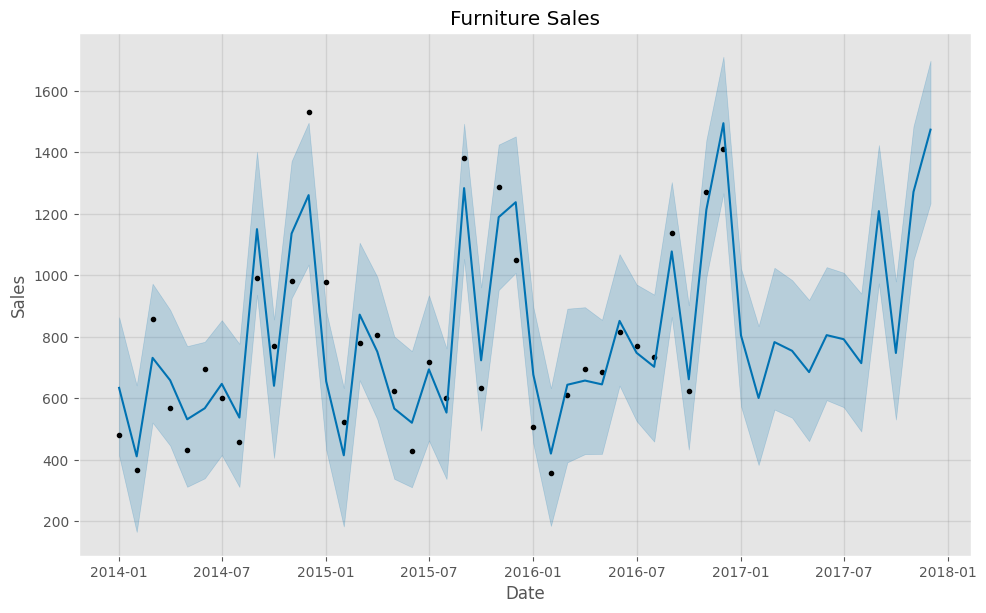

In [80]:
plt.figure(figsize=(18, 6))
furniture_model.plot(furniture_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Furniture Sales')
plt.show()

In [81]:
furniture_forecast.drop(columns=['multiplicative_terms', 'multiplicative_terms_lower','multiplicative_terms_upper'])

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,yhat
0,2014-01-01,681.587747,413.900617,863.623686,681.587747,681.587747,-47.448368,-47.448368,-47.448368,-47.448368,-47.448368,-47.448368,634.139379
1,2014-02-01,685.635861,165.834034,642.325974,685.635861,685.635861,-274.074947,-274.074947,-274.074947,-274.074947,-274.074947,-274.074947,411.560915
2,2014-03-01,689.292223,521.266519,972.628911,689.292223,689.292223,42.431306,42.431306,42.431306,42.431306,42.431306,42.431306,731.723529
3,2014-04-01,693.340337,446.457918,887.567125,693.340337,693.340337,-34.565318,-34.565318,-34.565318,-34.565318,-34.565318,-34.565318,658.775020
4,2014-05-01,697.257867,312.609684,769.752305,697.257867,697.257867,-165.309770,-165.309770,-165.309770,-165.309770,-165.309770,-165.309770,531.948097
5,2014-06-01,701.305982,340.308369,783.894472,701.305982,701.305982,-133.386435,-133.386435,-133.386435,-133.386435,-133.386435,-133.386435,567.919547
6,2014-07-01,705.223512,415.827943,854.026993,705.223512,705.223512,-58.042820,-58.042820,-58.042820,-58.042820,-58.042820,-58.042820,647.180692
7,2014-08-01,709.271626,312.209415,777.183941,709.271626,709.271626,-171.625954,-171.625954,-171.625954,-171.625954,-171.625954,-171.625954,537.645672
8,2014-09-01,713.319740,936.420249,1400.878438,713.319740,713.319740,436.757415,436.757415,436.757415,436.757415,436.757415,436.757415,1150.077155
9,2014-10-01,717.237270,406.677488,856.279000,717.237270,717.237270,-76.341805,-76.341805,-76.341805,-76.341805,-76.341805,-76.341805,640.895465


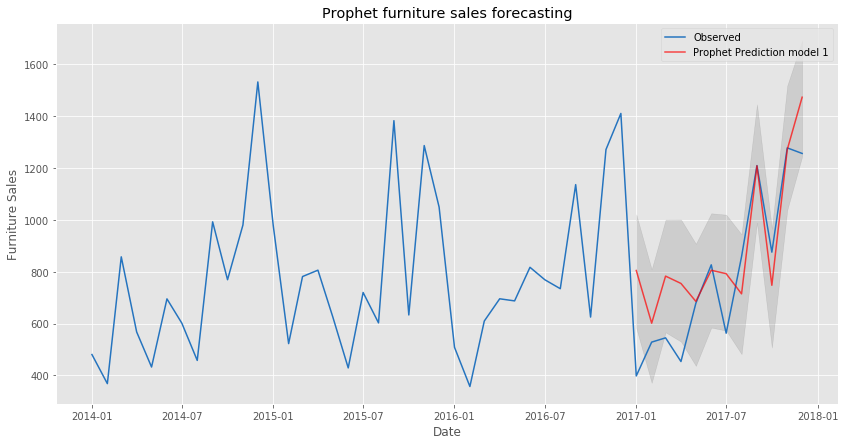

In [ ]:
rcParams['figure.figsize'] = 14, 7
plt.plot(df.index, df.values,label='Observed',color='#2574BF')
plt.plot(df[36:48].index,furniture_forecast[36:48]['yhat'].values,label='Prophet Prediction model 1', alpha= 0.7, color='red')
plt.fill_between(df[36:48].index,
                #lower sales
                furniture_forecast[36:48]['yhat_lower'].values,
                #upper sales
                furniture_forecast[36:48]['yhat_upper'].values, color='k', alpha=0.1)
plt.title('Prophet furniture sales forecasting')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend()
plt.show()

In [82]:
prophet_results=performance(df[36:48].values, furniture_forecast[36:48]['yhat'])
prophet_results

{'MSE': 37992.43, 'RMSE': 194.92, 'MAPE': 26.67}

In [83]:
test= furniture_forecast.set_index('ds')

### Prophet Second model

In [84]:
#add holidays
new_year_holidays = pd.DataFrame({'holiday': "New Year's Day", 'ds' : pd.to_datetime(['2014-01-01', '2015-01-01','2016-01-01'])})

furniture_model2 = Prophet(yearly_seasonality=True, holidays=new_year_holidays)
furniture_model2.fit(df_furniture_train)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkjiudls/808bhcdm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppkjiudls/uzjvqe09.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88936', 'data', 'file=/tmp/tmppkjiudls/808bhcdm.json', 'init=/tmp/tmppkjiudls/uzjvqe09.json', 'output', 'file=/tmp/tmppkjiudls/prophet_modelq78nud2g/prophet_model-20231011101031.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:10:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:10:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [85]:
furniture_forecast2 = furniture_model2.make_future_dataframe(periods=12, freq='MS')
furniture_forecast2 = furniture_model2.predict(furniture_forecast2)

<Figure size 1800x600 with 0 Axes>

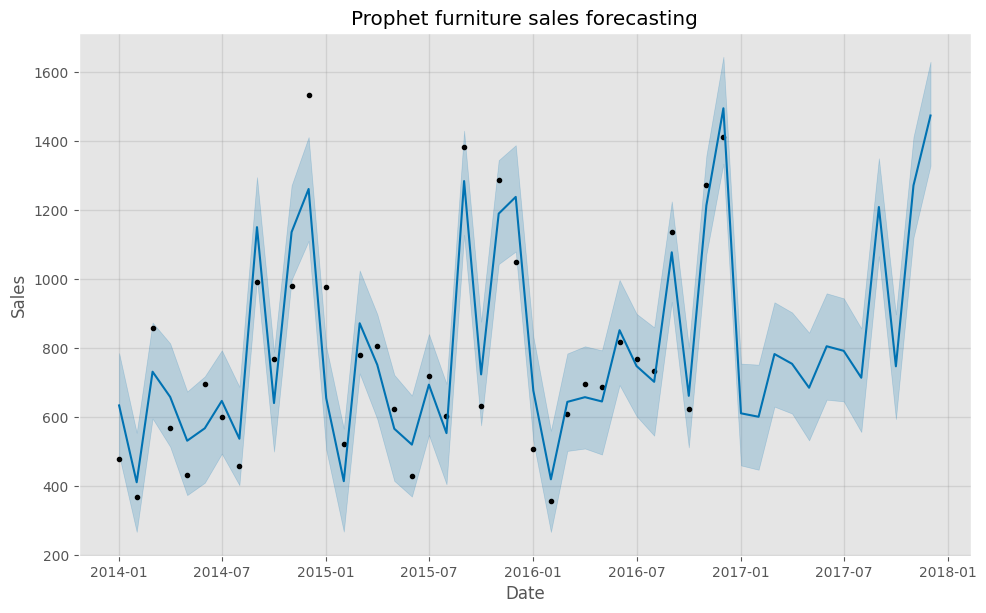

In [86]:
plt.figure(figsize=(18, 6))
furniture_model2.plot(furniture_forecast2, xlabel = 'Date', ylabel = 'Sales')
plt.title('Prophet furniture sales forecasting')
plt.show()

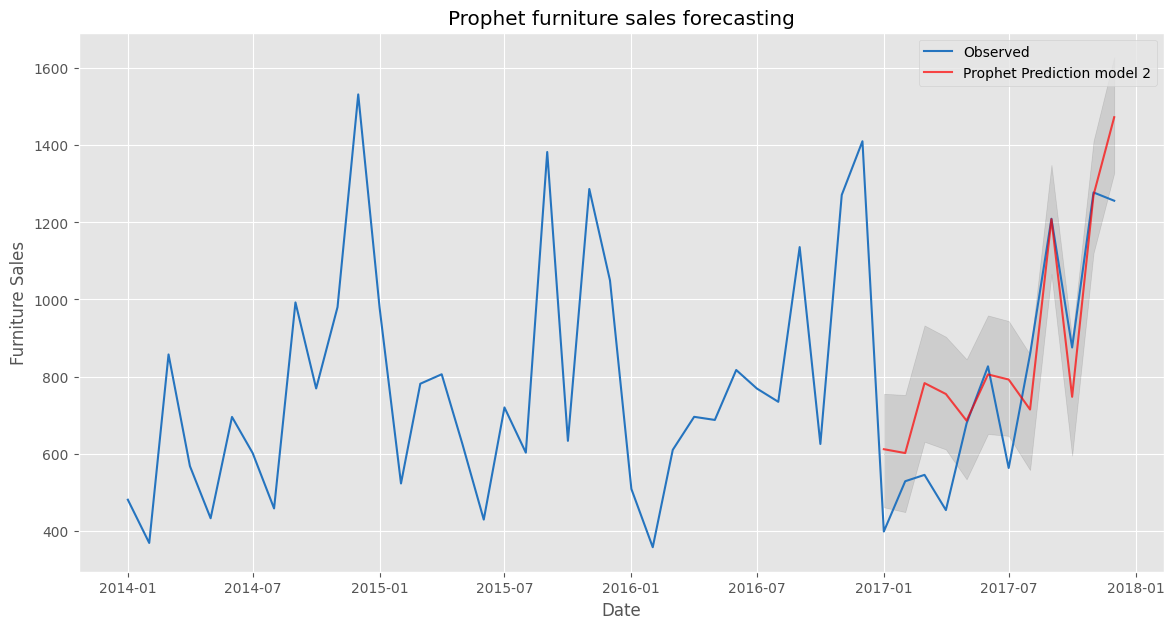

In [87]:
rcParams['figure.figsize'] = 14, 7
plt.plot(df.index, df.values,label='Observed',color='#2574BF')
plt.plot(df[36:48].index,furniture_forecast2[36:48]['yhat'].values,label='Prophet Prediction model 2', alpha= 0.7, color='red')
plt.fill_between(df[36:48].index,
                #lower sales
                furniture_forecast2[36:48]['yhat_lower'].values,
                #upper sales
                furniture_forecast2[36:48]['yhat_upper'].values, color='k', alpha=0.1)
plt.title('Prophet furniture sales forecasting')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend()
plt.show()

In [88]:
prophet_results2= performance(df[36:48].values, furniture_forecast2[36:48]['yhat'])
prophet_results

{'MSE': 37992.43, 'RMSE': 194.92, 'MAPE': 26.67}

In [89]:
test2= furniture_forecast2.set_index('ds')

## LSTM

In [90]:
train, test = np.array(df[:-12]), np.array(df[-12:])
train= train.reshape(-1,1)
test= test.reshape(-1,1)

In [91]:
#Scale train and test data to [-1, 1]
scaler = MinMaxScaler()
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

In [92]:
n_input = 12
# univariate
n_features = 1
#TimeseriesGenerator automatically transform a univariate time series dataset into a supervised learning problem.
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=10)

### Vanilla LSTM

In [93]:
######
#set the counter to repeat
n=20
store= np.zeros((12,n))
for i in range(n):
    model_vanilla = Sequential()
    model_vanilla.add(LSTM(50, activation='relu', input_shape=(12, 1)))
    #Add layer
    model_vanilla.add(Dense(100, activation='relu'))
    model_vanilla.add(Dense(100, activation='relu'))
    #Output
    model_vanilla.add(Dense(1))
    model_vanilla.compile(optimizer='adam', loss='mse')
    # 22
    model_vanilla.fit_generator(generator,epochs=200)

    pred_list = []

    batch = train[-n_input:].reshape((1, n_input, n_features))

    for j in range(n_input):
        pred_list.append(model_vanilla.predict(batch)[0])
        batch = np.append(batch[:,1:,:],[[pred_list[j]]],axis=1)

    df_predict_vanilla = pd.DataFrame(scaler.inverse_transform(pred_list),
                              index=df[-n_input:].index, columns=['Prediction'])


    store[:,i]=df_predict_vanilla['Prediction']
print(store)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 43ms/step
Epoch 1/200
3/3 [==============================] - 3s 19ms/step - loss: 0.1859
Epoch 2/200
3/3 [==============================] - 0s 15ms/step - loss: 0.1453
Epoch 3/200
3/3 [==============================] - 0s 22ms/step - loss: 0.1125
Epoch 4/200
3/3 [==============================] - 0s 20ms/step - loss: 0.0865
Epoch 5/200
3/3 [==============================] - 0s 23ms/step - loss: 0.0690
Epoch 6/200
3/3 [==============================] - 0s 20ms/step - loss: 0.0723
Epoch 7/200
3/3 [==============================] - 0s 20ms/step - loss: 0.0762
Epoch 8/200
3/3 [==============================] - 0s 26ms/step - loss: 0.0816
Epoch 9/200
3/3 [==============================] - 0s 20ms/step - loss: 0.0791
Epoch 10/200
3/3 [==============================] - 0s 13ms/step - loss: 0.0749
Epoch 11/200
3/3 [==============================] - 0s 12ms/step - loss: 0.0706
Epoch 12/200
3/3 [========

In [96]:
final_vanilla= np.zeros((store.shape[0],1))
for i in range(store.shape[0]):

    final_vanilla[i]=np.mean(store[i,:])
final_vanilla=final_vanilla.reshape((12,))


vanilla_lstm= performance(df[-12:],final_vanilla)
vanilla_lstm

{'MSE': 21256.15, 'RMSE': 145.79, 'MAPE': 18.99}

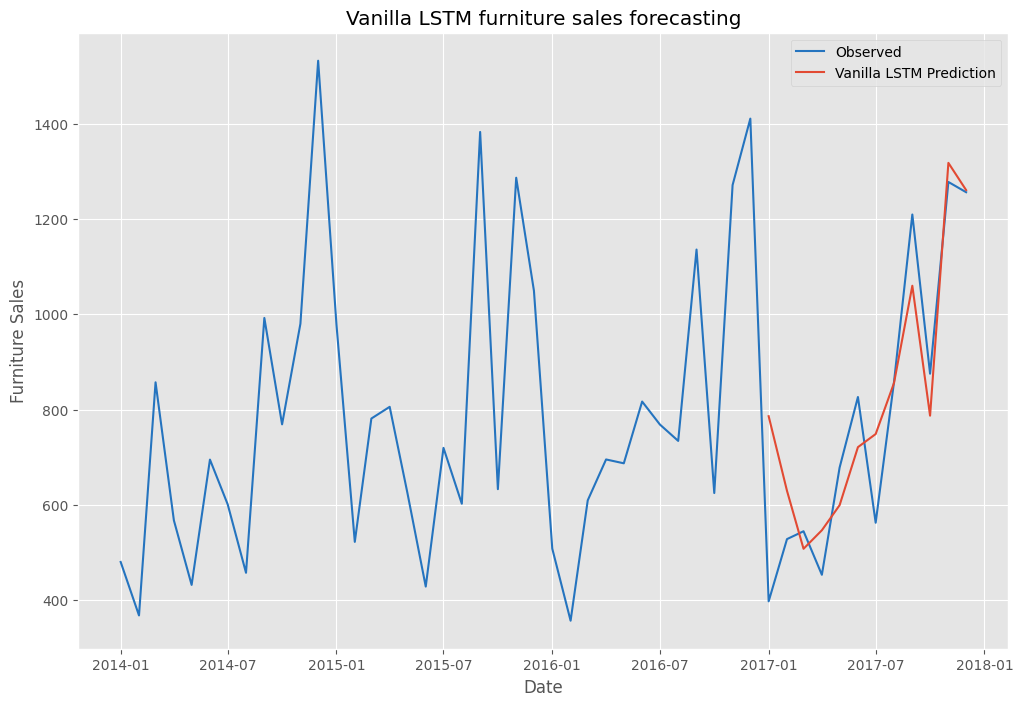

In [98]:
# report performance
rcParams['figure.figsize'] = 12, 8
# line plot of observed vs predicted
plt.plot(df.index,df,label="Observed",color='#2574BF')
plt.plot(df[36:].index,final_vanilla,label="Vanilla LSTM Prediction")
plt.title('Vanilla LSTM furniture sales forecasting')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend()
plt.show()

### Stacked LSTM

In [99]:
######
n=20
store2= np.zeros((12,n))
for i in range(n):
    model_stacked = Sequential()
    #In stacked LSTM, we should output a sequence rather than a single value for each input -> return_sequences=True
    model_stacked.add(LSTM(50, activation='relu', return_sequences = True, input_shape=(12, 1)))
    model_stacked.add(LSTM(50, activation='relu'))
    model_stacked.add(Dense(100, activation='relu'))
    model_stacked.add(Dense(50, activation='relu'))
    model_stacked.add(Dense(1))
    model_stacked.compile(optimizer='adam', loss='mse')
    model_stacked.fit_generator(generator,epochs=200)

    pred_list_s = []

    batch = train[-n_input:].reshape((1, n_input, n_features))

    for j in range(n_input):
        pred_list_s.append(model_stacked.predict(batch)[0])
        batch = np.append(batch[:,1:,:],[[pred_list_s[j]]],axis=1)

    df_predict_stacked = pd.DataFrame(scaler.inverse_transform(pred_list_s),
                              index=df[-n_input:].index, columns=['Prediction'])


    store2[:,i]=df_predict_stacked['Prediction']
print(store2)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 29ms/step
Epoch 1/200
3/3 [==============================] - 3s 25ms/step - loss: 0.2072
Epoch 2/200
3/3 [==============================] - 0s 23ms/step - loss: 0.1831
Epoch 3/200
3/3 [==============================] - 0s 31ms/step - loss: 0.1622
Epoch 4/200
3/3 [==============================] - 0s 21ms/step - loss: 0.1384
Epoch 5/200
3/3 [==============================] - 0s 23ms/step - loss: 0.1126
Epoch 6/200
3/3 [==============================] - 0s 24ms/step - loss: 0.0853
Epoch 7/200
3/3 [==============================] - 0s 22ms/step - loss: 0.0644
Epoch 8/200
3/3 [==============================] - 0s 22ms/step - loss: 0.0765
Epoch 9/200
3/3 [==============================] - 0s 23ms/step - loss: 0.0948
Epoch 10/200
3/3 [==============================] - 0s 22ms/step - loss: 0.0913
Epoch 11/200
3/3 [==============================] - 0s 19ms/step - loss: 0.0760
Epoch 12/200
3/3 [========

In [101]:
final_stacked2= np.zeros((store2.shape[0],1))
for i in range(store2.shape[0]):

    final_stacked2[i]=np.mean(store2[i,:])
final_stacked2=final_stacked2.reshape((12,))

stacked_lstm= performance(df[-12:],final_stacked2)
stacked_lstm

{'MSE': 19339.34, 'RMSE': 139.07, 'MAPE': 17.88}

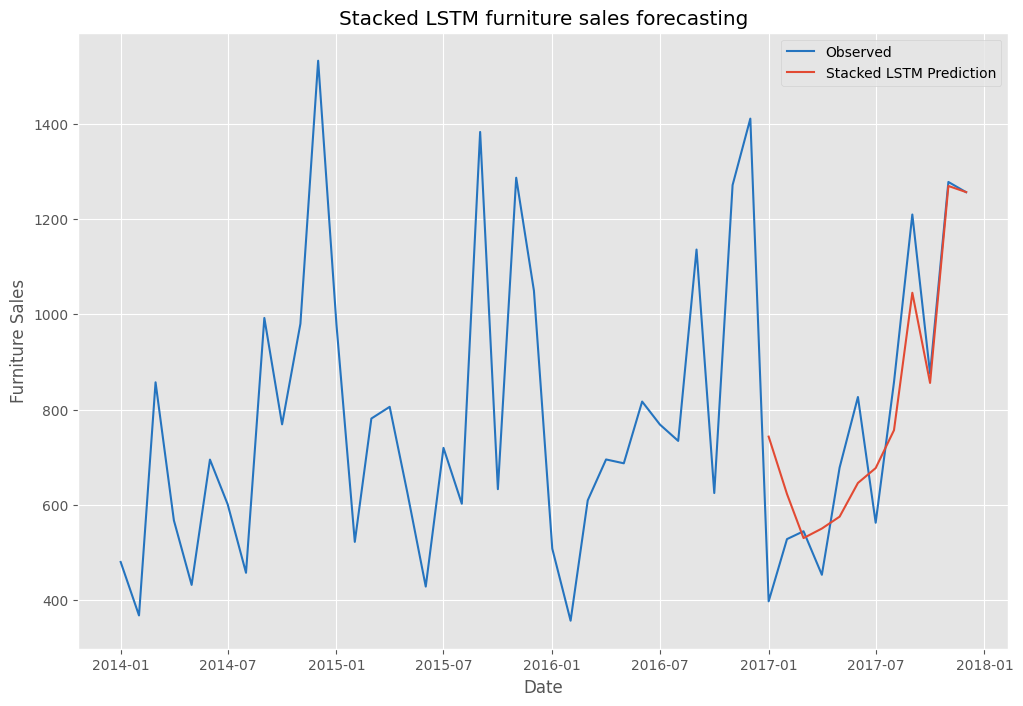

In [102]:
# report performance
rcParams['figure.figsize'] = 12, 8
# line plot of observed vs predicted
plt.plot(df.index,df,label="Observed",color='#2574BF')
plt.plot(df[36:].index,final_stacked2,label="Stacked LSTM Prediction")
plt.title('Stacked LSTM furniture sales forecasting')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend()
plt.show()

### Bidirectional LSTM

In [103]:
# define model
model_bi = Sequential()
model_bi.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(12, 1)))
model_bi.add(Dense(1))
model_bi.compile(optimizer='adam', loss='mse')

In [104]:
model_bi.fit_generator(generator,epochs=200)

Epoch 1/200
3/3 [==============================] - 7s 41ms/step - loss: 0.1996
Epoch 2/200
3/3 [==============================] - 0s 43ms/step - loss: 0.1630
Epoch 3/200
3/3 [==============================] - 0s 43ms/step - loss: 0.1333
Epoch 4/200
3/3 [==============================] - 0s 37ms/step - loss: 0.1097
Epoch 5/200
3/3 [==============================] - 0s 39ms/step - loss: 0.0916
Epoch 6/200
3/3 [==============================] - 0s 23ms/step - loss: 0.0750
Epoch 7/200
3/3 [==============================] - 0s 30ms/step - loss: 0.0686
Epoch 8/200
3/3 [==============================] - 0s 24ms/step - loss: 0.0631
Epoch 9/200
3/3 [==============================] - 0s 38ms/step - loss: 0.0659
Epoch 10/200
3/3 [==============================] - 0s 20ms/step - loss: 0.0692
Epoch 11/200
3/3 [==============================] - 0s 12ms/step - loss: 0.0754
Epoch 12/200
3/3 [==============================] - 0s 12ms/step - loss: 0.0748
Epoch 13/200
3/3 [==============================]

In [105]:
pred_list_b = []

batch = train[-n_input:].reshape((1, n_input, n_features))

for i in range(n_input):
    pred_list_b.append(model_bi.predict(batch)[0])
    batch = np.append(batch[:,1:,:],[[pred_list_b[i]]],axis=1)

df_predict_bi = pd.DataFrame(scaler.inverse_transform(pred_list_b),
                          index=df[-n_input:].index, columns=['Prediction'])

1/1 [==============================] - 0s 33ms/step


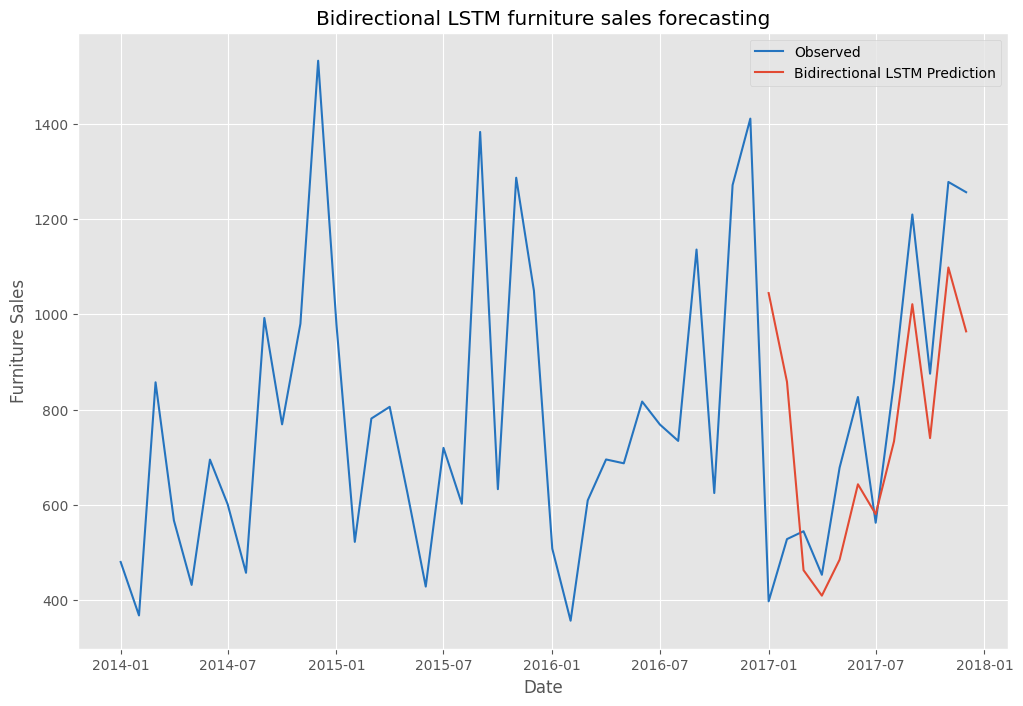

In [106]:
# report performance
rcParams['figure.figsize'] = 12, 8
# line plot of observed vs predicted
plt.plot(df.index,df,label="Observed",color='#2574BF')
plt.plot(df[36:].index,df_predict_bi,label="Bidirectional LSTM Prediction")
plt.title('Bidirectional LSTM furniture sales forecasting')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend()
plt.show()

In [107]:
bi_lstm= performance(df[-12:],df_predict_bi['Prediction'] )
bi_lstm

{'MSE': 66178.95, 'RMSE': 257.25, 'MAPE': 32.21}

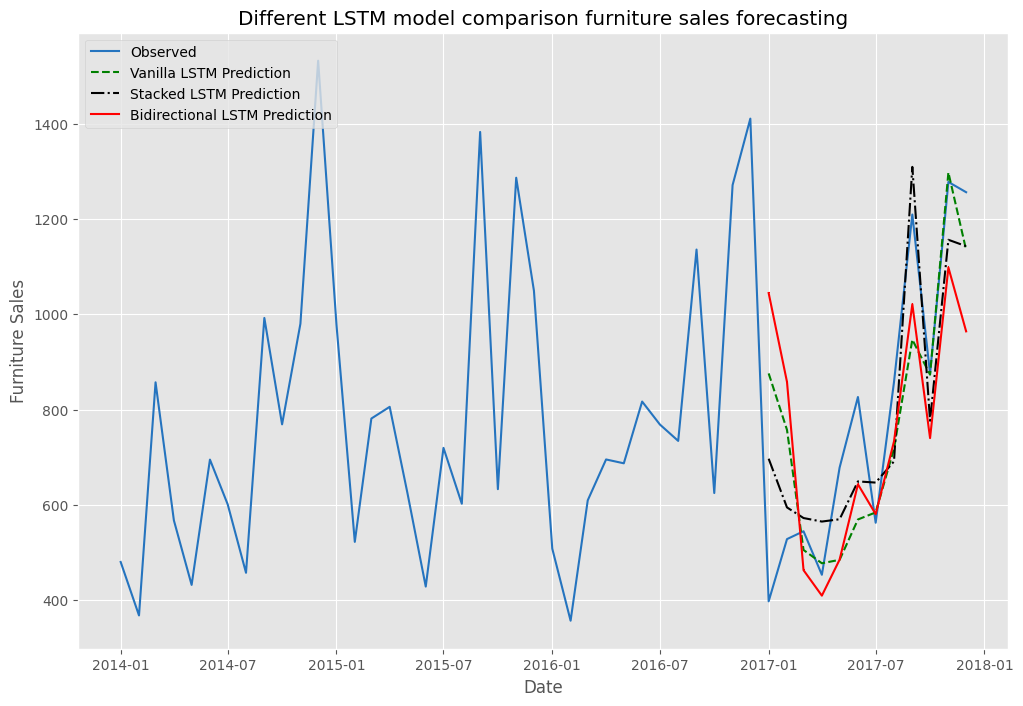

In [108]:
# report performance
rcParams['figure.figsize'] = 12, 8
# line plot of observed vs predicted
plt.plot(df.index,df,label="Observed",color='#2574BF')
#Vanilla LSTM
plt.plot(df[36:].index,df_predict_vanilla,label="Vanilla LSTM Prediction",linestyle= "--", color='g')
#STacked LSTM
plt.plot(df[36:].index,df_predict_stacked,label="Stacked LSTM Prediction",linestyle= "-.", color="black")
#Bidirectional LSTM
plt.plot(df[36:].index,df_predict_bi,label="Bidirectional LSTM Prediction",marker=',',color='r')
plt.title('Different LSTM model comparison furniture sales forecasting')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend(loc='upper left')
plt.show()

### LSTM model 1

In [109]:
X = df.values

In [110]:
# Transform Time Series to Supervised Learning
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df
# Make a differenced series to make time-series stationary
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [111]:
# Transform Time Series to Stationary
raw_values = df.values
diff_values = difference(raw_values, 1)

In [112]:
# Transform Time Series to Supervised Learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

In [113]:
train_size = int(len(df) * 0.75)
trainset, testset= supervised_values[0:-12], supervised_values[-12:]

In [114]:
# Scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

In [115]:
#  Invert the scale on forecasts to the original scale
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

In [116]:
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(trainset, testset)

In [117]:
# fit an LSTM network to train the data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        #epoch can be changed to 1
        model.fit(X, y, epochs=5, batch_size=batch_size, verbose=1, shuffle=False)
        model.reset_states()
    return model

In [118]:
# fit the model
lstm_model = fit_lstm(train_scaled, 1, 100, 4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

Epoch 1/5
35/35 [==============================] - 2s 2ms/step - loss: 0.2464
Epoch 2/5
35/35 [==============================] - 0s 3ms/step - loss: 0.2423
Epoch 3/5
35/35 [==============================] - 0s 3ms/step - loss: 0.2386
Epoch 4/5
35/35 [==============================] - 0s 3ms/step - loss: 0.2351
Epoch 5/5
35/35 [==============================] - 0s 3ms/step - loss: 0.2318
Epoch 1/5
35/35 [==============================] - 0s 3ms/step - loss: 0.2286
Epoch 2/5
35/35 [==============================] - 0s 2ms/step - loss: 0.2254
Epoch 3/5
35/35 [==============================] - 0s 3ms/step - loss: 0.2222
Epoch 4/5
35/35 [==============================] - 0s 3ms/step - loss: 0.2191
Epoch 5/5
35/35 [==============================] - 0s 3ms/step - loss: 0.2161
Epoch 1/5
35/35 [==============================] - 0s 2ms/step - loss: 0.2130
Epoch 2/5
35/35 [==============================] - 0s 2ms/step - loss: 0.2103
Epoch 3/5
35/35 [==============================] - 0s 3ms/step -

array([[ 0.26288676],
       [ 0.48176426],
       [-0.40633816],
       [ 0.5358017 ],
       [ 0.4198525 ],
       [ 0.06155797],
       [ 0.28426525],
       [ 0.41985732],
       [-0.38317752],
       [ 0.3061483 ],
       [ 0.02459715],
       [-0.78521144],
       [-0.00468371],
       [ 0.11525141],
       [ 0.13863175],
       [ 0.04988854],
       [ 0.28276658],
       [ 0.40867484],
       [ 0.03142175],
       [ 0.40489304],
       [-0.9100331 ],
       [ 0.58486384],
       [-0.17987151],
       [-0.3524589 ],
       [-0.12842123],
       [ 0.2961123 ],
       [ 0.10096289],
       [-0.00263777],
       [ 0.14704473],
       [ 0.03152404],
       [ 0.26387388],
       [ 0.33147728],
       [-0.33810443],
       [ 0.815842  ],
       [-0.20244725]], dtype=float32)

In [119]:
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

In [120]:
# walk-forward validation on the test data
predictions_lstm1 = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions_lstm1.append(yhat)
    expected = raw_values[len(train_scaled) + i ]
    print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

1/1 [==============================] - 0s 40ms/step
Month=1, Predicted=1111.653756, Expected=1410.719808
1/1 [==============================] - 0s 40ms/step
Month=2, Predicted=274.736836, Expected=397.602133
1/1 [==============================] - 0s 61ms/step
Month=3, Predicted=688.828971, Expected=528.179800
1/1 [==============================] - 0s 43ms/step
Month=4, Predicted=632.797003, Expected=544.672240
1/1 [==============================] - 0s 43ms/step
Month=5, Predicted=632.737837, Expected=453.297905
1/1 [==============================] - 0s 44ms/step
Month=6, Predicted=689.020942, Expected=678.302328
1/1 [==============================] - 0s 42ms/step
Month=7, Predicted=733.827743, Expected=826.460291
1/1 [==============================] - 0s 42ms/step
Month=8, Predicted=921.539165, Expected=562.524857
1/1 [==============================] - 0s 50ms/step
Month=9, Predicted=877.067077, Expected=857.881889
1/1 [==============================] - 0s 44ms/step
Month=10, Predicted

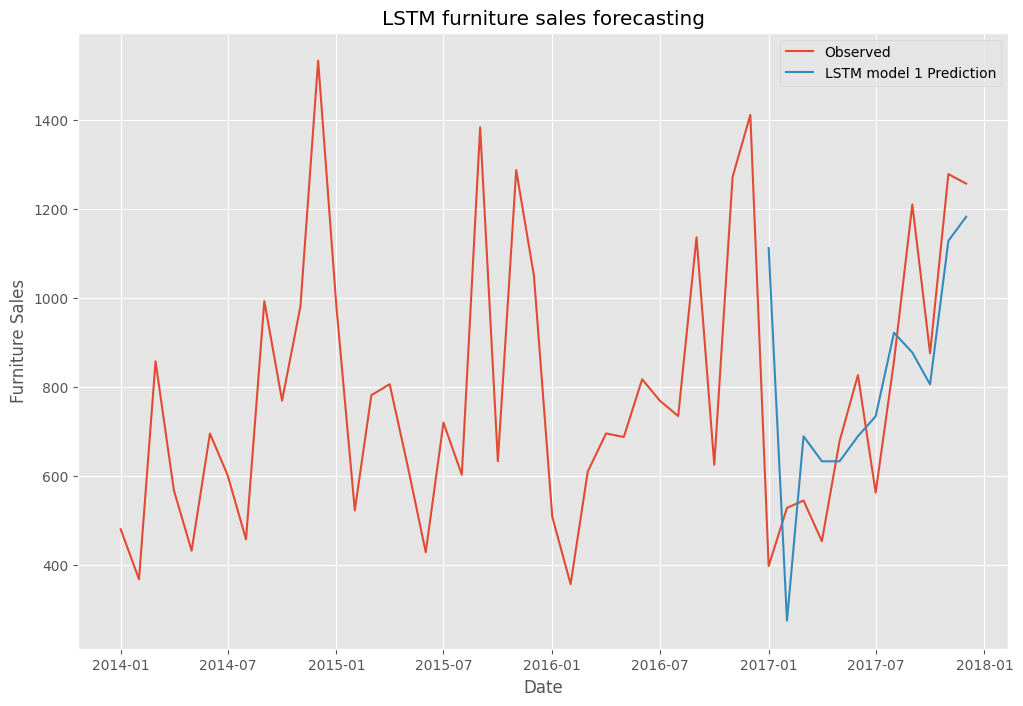

In [121]:
# report performance
rcParams['figure.figsize'] = 12, 8
# line plot of observed vs predicted
plt.plot(df.index,df,label="Observed")
plt.plot(df[36:].index,predictions_lstm1,label="LSTM model 1 Prediction")
plt.title('LSTM furniture sales forecasting')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend()
plt.show()

In [122]:
lstm1= performance(raw_values[-12:], predictions_lstm1)
lstm1

{'MSE': 68742.01, 'RMSE': 262.19, 'MAPE': 34.0}

### Convolutional Neural Network

In [123]:
dfcnn= np.array(df)
dfcnn= dfcnn.reshape(-1,1)
#Scale data
scaler = MinMaxScaler()
ts = scaler.fit_transform(dfcnn)

In [124]:
#Set the timestep
timestep = 12
X= []
Y=[]
raw_data=ts
for i in range(len(raw_data)- (timestep)):
    X.append(raw_data[i:i+timestep])
    Y.append(raw_data[i+timestep])


X=np.asanyarray(X)
Y=np.asanyarray(Y)
#Set the trainset
X_train = X[:24,:,:]
Y_train = Y[:24]
#Set the testset
X_test = X[24:,:,:]
Y_test= Y[24:]

In [125]:
#define model
cnn_model = Sequential()
cnn_model.add(Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(12, 1)))
cnn_model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
cnn_model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(100, activation='relu'))
cnn_model.add(Dense(1))
cnn_model.compile(optimizer='adam', loss='mse')


# fit model
cnn_model.fit(X_train, Y_train, epochs=200, verbose=1)

Epoch 1/200
1/1 [==============================] - 1s 1s/step - loss: 0.1924
Epoch 2/200
1/1 [==============================] - 0s 13ms/step - loss: 0.1387
Epoch 3/200
1/1 [==============================] - 0s 18ms/step - loss: 0.0984
Epoch 4/200
1/1 [==============================] - 0s 16ms/step - loss: 0.0784
Epoch 5/200
1/1 [==============================] - 0s 14ms/step - loss: 0.0881
Epoch 6/200
1/1 [==============================] - 0s 14ms/step - loss: 0.0950
Epoch 7/200
1/1 [==============================] - 0s 17ms/step - loss: 0.0854
Epoch 8/200
1/1 [==============================] - 0s 16ms/step - loss: 0.0735
Epoch 9/200
1/1 [==============================] - 0s 16ms/step - loss: 0.0676
Epoch 10/200
1/1 [==============================] - 0s 18ms/step - loss: 0.0674
Epoch 11/200
1/1 [==============================] - 0s 17ms/step - loss: 0.0688
Epoch 12/200
1/1 [==============================] - 0s 17ms/step - loss: 0.0692
Epoch 13/200
1/1 [==============================] -

In [126]:
# Validate data
preds = cnn_model.predict(X_test)
preds=np.array(preds)
preds=preds.reshape(-1,1)
preds = scaler.inverse_transform(preds)


Y_test=np.asanyarray(Y_test)
Y_test=Y_test.reshape(-1,1)
Y_test = scaler.inverse_transform(Y_test)


Y_train=np.asanyarray(Y_train)
Y_train=Y_train.reshape(-1,1)
Y_train = scaler.inverse_transform(Y_train)


1/1 [==============================] - 0s 121ms/step


In [127]:
cnn= performance(Y_test,preds)
cnn_predict= preds.reshape((12,))
cnn

{'MSE': 48152.05, 'RMSE': 219.44, 'MAPE': 27.35}

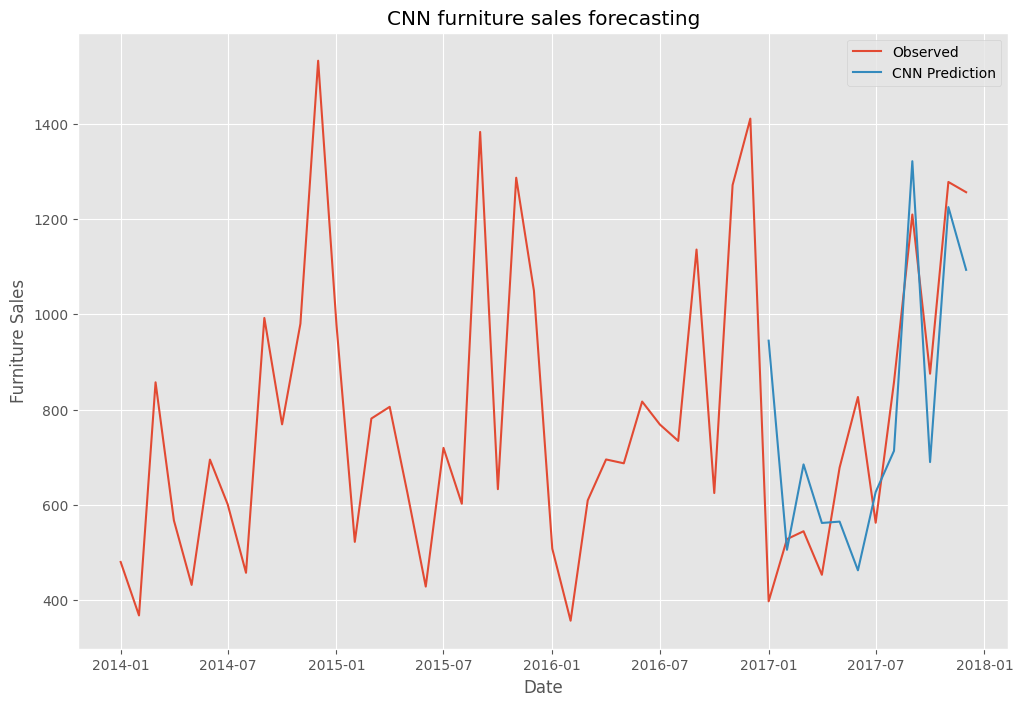

In [128]:
# report performance
rcParams['figure.figsize'] = 12, 8
# line plot of observed vs predicted
plt.plot(df.index,df,label="Observed")
plt.plot(df[36:].index,preds,label="CNN Prediction")
plt.title('CNN furniture sales forecasting')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend()
plt.show()

#### Source:
    
https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/

https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/


https://www.kaggle.com/fatmakursun/predict-sales-time-series-with-cnn

## Results:

In [132]:
# intialise data of lists.
prediction_data = {'Model':['ARIMA','SARIMA 1','SARIMA 2','DES','TES','Prophet1','Prophet2',
                           'Vanilla LSTM','Stacked LSTM','Bidirectional LSTM','LSTM 1','CNN'],

                    'MSE':[arima_results['MSE'],sarima_results['MSE'],sarima_results2['MSE'],
                           DES_results['MSE'],TES_results['MSE'],prophet_results['MSE'],prophet_results2['MSE'],
                           vanilla_lstm['MSE'],stacked_lstm['MSE'],bi_lstm['MSE'],lstm1['MSE'],cnn['MSE']
                          ],
                  'RMSE':[arima_results['RMSE'],sarima_results['RMSE'],sarima_results2['RMSE'],
                          DES_results['RMSE'],TES_results['RMSE'],prophet_results['RMSE'],prophet_results2['RMSE'],
                          vanilla_lstm['RMSE'],stacked_lstm['RMSE'],bi_lstm['RMSE'],lstm1['RMSE'],cnn['RMSE']
                         ],
                  'MAPE':[arima_results['MAPE'],sarima_results['MAPE'],sarima_results2['MAPE'],
                          DES_results['MAPE'],TES_results['MAPE'],prophet_results['MAPE'],prophet_results2['MAPE'],
                          vanilla_lstm['MAPE'],stacked_lstm['MAPE'],bi_lstm['MAPE'],lstm1['MAPE'],cnn['MAPE']
                         ]}

# Create DataFrame
prediction_table = pd.DataFrame(prediction_data)
prediction_table

,Model,MSE,RMSE,MAPE
0,ARIMA,79779.20,282.45,35.04
1,SARIMA 1,42305.37,205.68,28.89
2,SARIMA 2,55497.86,235.58,33.50
3,DES,420545.71,648.49,100.74
4,TES,41955.36,204.83,27.81
5,Prophet1,37992.43,194.92,26.67
6,Prophet2,27986.69,167.29,22.62
7,Vanilla LSTM,21256.15,145.79,18.99
8,Stacked LSTM,19339.34,139.07,17.88
9,Bidirectional LSTM,66178.95,257.25,32.21


In [137]:
print(test2)

                 trend   yhat_lower   yhat_upper  trend_lower  trend_upper  \
ds                                                                           
2014-01-01  665.628860   490.308834   785.611105   665.628860   665.628860   
2014-02-01  669.672318   268.173532   555.166423   669.672318   669.672318   
2014-03-01  673.324474   596.231099   873.992598   673.324474   673.324474   
2014-04-01  677.367931   514.710574   813.555100   677.367931   677.367931   
2014-05-01  681.280955   374.605113   674.389631   681.280955   681.280955   
2014-06-01  685.324413   410.371296   718.197593   685.324413   685.324413   
2014-07-01  689.237436   494.594476   793.588290   689.237436   689.237436   
2014-08-01  693.280894   403.434838   688.105033   693.280894   693.280894   
2014-09-01  697.324352  1000.345213  1294.789786   697.324352   697.324352   
2014-10-01  701.237375   500.455467   789.284501   701.237375   701.237375   
2014-11-01  705.280833   997.330472  1270.942951   705.280833   

In [140]:
print(test)

[[0.03465443]
 [0.1457437 ]
 [0.15977469]
 [0.08203775]
 [0.27346081]
 [0.39950656]
 [0.17496284]
 [0.42623856]
 [0.72538584]
 [0.44111043]
 [0.78350003]
 [0.76519262]]


In [139]:
# intialise data of lists.
prediction_data = {
        'Test Set':df[-12:],
        'ARIMA':arima_predict,
        'SARIMA':sarima_predict_1.predicted_mean,
        'DES':yhat_DES,
        'TES':yhat_TES,
        # 'Prophet1':test[36:48]['yhat'],
        'Prophet2':test2[36:48]['yhat']}

# Create DataFrame
prediction_table = pd.DataFrame(prediction_data)
prediction_table

,Test Set,ARIMA,SARIMA,DES,TES,Prophet2
2017-01-01,397.602133,831.385306,803.994588,1264.321387,767.765819,611.317264
2017-02-01,528.179800,829.595977,461.016739,1287.926358,527.251522,601.273672
2017-03-01,544.672240,840.857132,717.583256,1311.531329,863.932442,782.875321
2017-04-01,453.297905,585.827299,764.867261,1335.136300,803.176381,754.558841
2017-05-01,678.302328,570.203570,648.086385,1358.741271,697.294935,685.313846
2017-06-01,826.460291,702.834480,572.567132,1382.346242,765.005861,805.413754
2017-07-01,562.524857,707.430821,737.887081,1405.951213,811.254225,792.176215
2017-08-01,857.881889,747.601132,651.320055,1429.556183,724.534912,714.293983
2017-09-01,1209.508583,842.811958,1291.261366,1453.161154,1304.412092,1208.429315
2017-10-01,875.362728,855.146867,629.973778,1476.766125,816.024284,747.343553


In [135]:
# intialise data of lists.
prediction_data2 = {
        'Test Set':df[-12:],
        'Vanilla LSTM':df_predict_vanilla['Prediction'],
        'Stacked LSTM':df_predict_stacked['Prediction'],
        'Bidirectional LSTM':df_predict_bi['Prediction'],
        'LSTM model 1': predictions_lstm1,
        'CNN': cnn_predict}

# Create DataFrame
prediction_table2 = pd.DataFrame(prediction_data2)
prediction_table2

,Test Set,Vanilla LSTM,Stacked LSTM,Bidirectional LSTM,LSTM model 1,CNN
order_date,,,,,,
2017-01-01,397.602133,875.984138,696.927677,1044.631377,1111.653756,944.700134
2017-02-01,528.179800,757.567758,594.695847,858.215629,274.736836,505.766388
2017-03-01,544.672240,505.354014,572.394649,462.943330,688.828971,684.979492
2017-04-01,453.297905,477.470156,565.002205,409.517251,632.797003,562.072266
2017-05-01,678.302328,484.692298,569.863412,485.074481,632.737837,564.899902
2017-06-01,826.460291,569.384527,649.269864,643.262756,689.020942,462.664093
2017-07-01,562.524857,584.233484,646.822087,580.581988,733.827743,626.988953
2017-08-01,857.881889,718.070993,691.307587,733.306723,921.539165,713.412476
2017-09-01,1209.508583,946.872615,1309.467064,1021.247437,877.067077,1321.388794


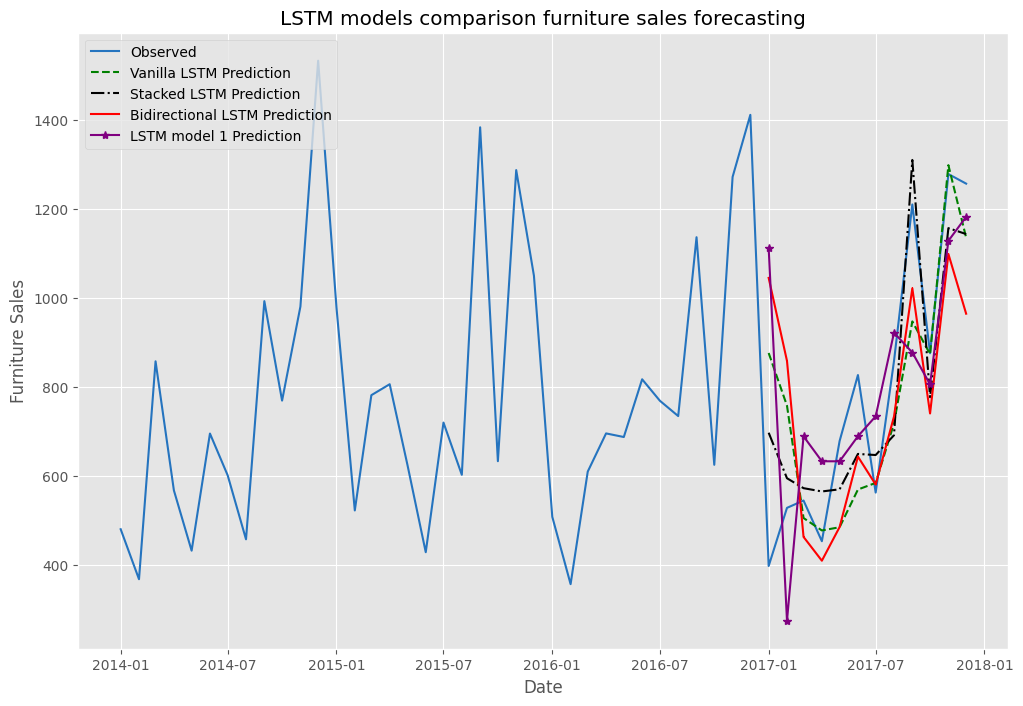

In [141]:
# report performance
rcParams['figure.figsize'] = 12, 8
# line plot of observed vs predicted
plt.plot(df.index,df,label="Observed",color='#2574BF')
#Vanilla LSTM
plt.plot(df[36:].index,df_predict_vanilla,label="Vanilla LSTM Prediction",linestyle= "--", color='g')
#STacked LSTM
plt.plot(df[36:].index,df_predict_stacked,label="Stacked LSTM Prediction",linestyle= "-.", color="black")
#Bidirectional LSTM
plt.plot(df[36:].index,df_predict_bi,label="Bidirectional LSTM Prediction",marker=',',color='r')
#LSTM model 2
plt.plot(df[36:].index,predictions_lstm1,label="LSTM model 1 Prediction",marker="*",color="purple")
plt.title('LSTM models comparison furniture sales forecasting')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend(loc='upper left')
plt.show()

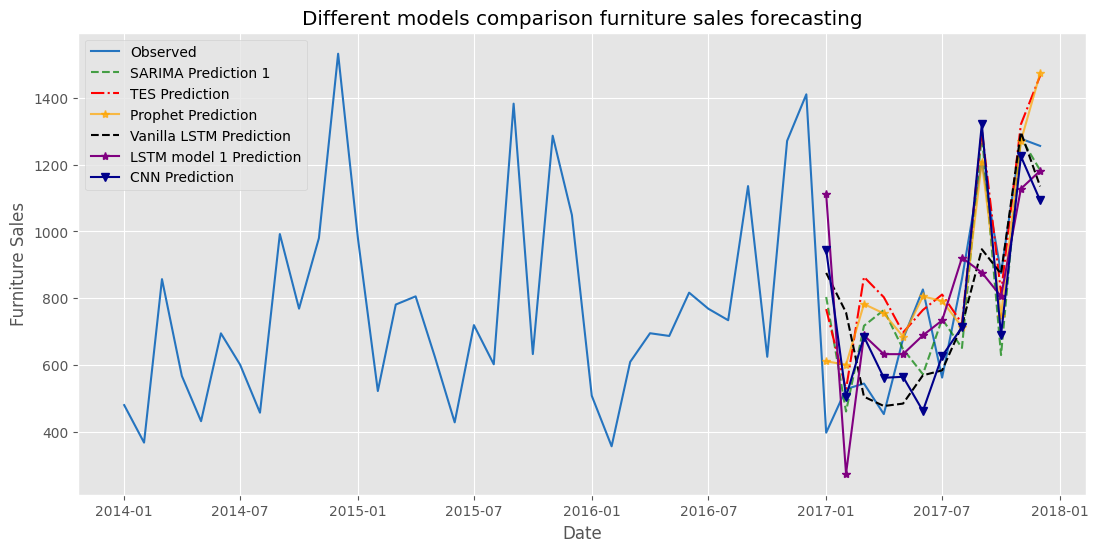

In [142]:
from pylab import rcParams
rcParams['figure.figsize'] = 13, 6
#observed plot
plt.plot(df.index, df, color='#2574BF',label='Observed')
#SARIMA
plt.plot(sarima_predict_1.predicted_mean, label='SARIMA Prediction 1', alpha= 0.7,linestyle= "--", color='g')
#TES
yhat_TES = TES_predict.values.tolist()
y = df.values.tolist()
plt.plot(TES_predict.index, yhat_TES, color='r',label='TES Prediction',linestyle= "-.")
#Prophet 2
plt.plot(df[36:48].index,furniture_forecast2[36:48]['yhat'].values,label='Prophet Prediction', alpha= 0.7, color='Orange',marker= "*")
#Vanilla LSTM
plt.plot(df[36:].index,df_predict_vanilla,label="Vanilla LSTM Prediction",linestyle= "--", color='black')
#LSTM model 2
plt.plot(df[36:].index,predictions_lstm1,label="LSTM model 1 Prediction",marker="*",color="purple")
#CNN
plt.plot(df[36:].index,preds,label="CNN Prediction",marker='v',color='darkblue')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend()
plt.title('Different models comparison furniture sales forecasting')
plt.show()

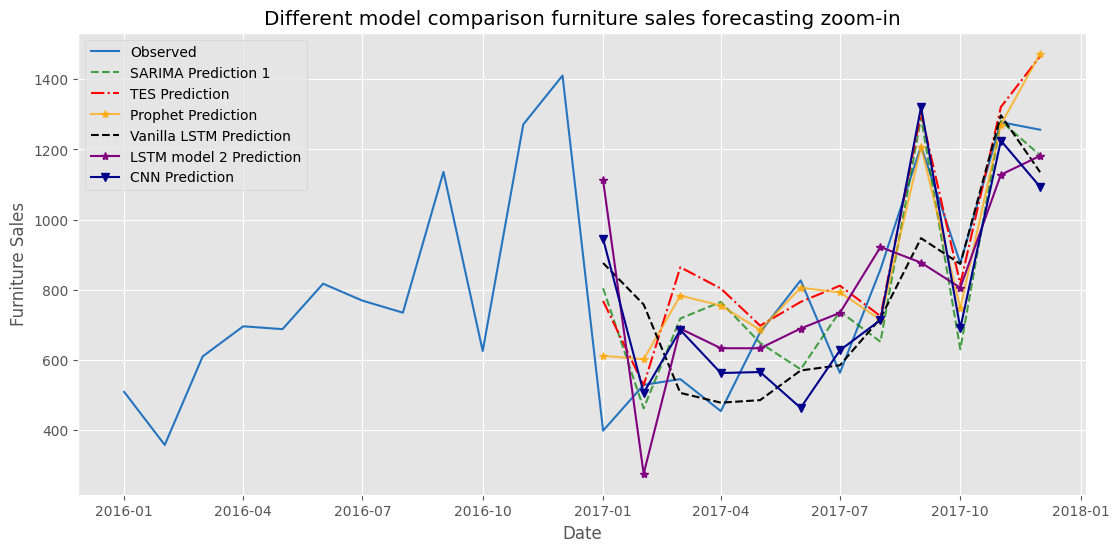

In [143]:
from pylab import rcParams
rcParams['figure.figsize'] = 13, 6
#observed plot
plt.plot(df[24:].index, df[24:], color='#2574BF',label='Observed')
#SARIMA
plt.plot(sarima_predict_1.predicted_mean, label='SARIMA Prediction 1', alpha= 0.7,linestyle= "--", color='g')
#TES
yhat_TES = TES_predict.values.tolist()
y = df.values.tolist()
plt.plot(TES_predict.index, yhat_TES, color='r',label='TES Prediction',linestyle= "-.")
#Prophet 2
plt.plot(df[36:48].index,furniture_forecast2[36:48]['yhat'].values,label='Prophet Prediction', alpha= 0.7, color='Orange',marker= "*")
#Vanilla LSTM
plt.plot(df[36:].index,df_predict_vanilla,label="Vanilla LSTM Prediction",linestyle= "--", color='black')
#LSTM model 2
plt.plot(df[36:].index,predictions_lstm1,label="LSTM model 2 Prediction",marker="*",color="purple")
#CNN
plt.plot(df[36:].index,preds,label="CNN Prediction",marker='v',color='darkblue')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend()
plt.title('Different model comparison furniture sales forecasting zoom-in')
plt.show()